In [1]:
#The below code parses all the xml files 
#All the news articles and relevant metadata are put into the all_news_result list
#All the commentary articles and relevant metadata are put into the all_commentary_result list

import xml.etree.ElementTree as ET
import html2text
from pprint import pprint
import json, os, csv, re

escape_illegal_xml_characters = lambda x: re.sub(u'[\x00-\x08\x0b\x0c\x0e-\x1F\uD800-\uDFFF\uFFFE\uFFFF]', '', x)
all_news = []
all_commentary = []
for root, dirs, files in os.walk("."):
    for name in files:
        if '.xml' in name:
            if "News" in root:
                all_news.append(os.path.join(root, name))
            if "Commentary" in root:
                all_commentary.append(os.path.join(root, name))
                
def commentary_parsing(root):
    count = 0
    while root[0][count].tag != 'item':
        count += 1
    assert root[0][-1].tag == 'item'
    for item in root[0][count:]:
        tags = []
        affiliation = ''
        author = ''
        contentEncoded = ''
        for child in item:
            if child.tag == 'title':
                title = child.text
            elif child.tag == 'link':
                link = child.text
            elif child.tag == '{http://purl.org/rss/1.0/modules/content/}encoded':
                contentEncoded = child.text
            elif child.tag == 'pubDate':
                date = child.text
            elif child.tag == 'category':
                if child.text != 'Uncategorized' and 'affiliation' not in child.text.lower() and 'author' not in child.text.lower():
                    tags.append(child.text)
                elif 'affiliation:' in child.text.lower():
                    affiliation = re.sub("affiliation:", "", child.text, flags=re.I)
                elif 'author:' in child.text.lower():
                    author = re.sub("author:", "", child.text, flags=re.I)
        all_tags = ', '.join(tags)
        result = [title,date,all_tags,author,affiliation,link,contentEncoded]
        all_commentary_result.append(result)
        
        
def news_parsing(root):
    count = 0
    while root[0][count].tag != 'item':
        count += 1
    assert root[0][-1].tag == 'item'
    for item in root[0][count:]:
        tags = []
        affiliation = ''
        author = ''
        contentEncoded = ''
        for child in item:
            if child.tag == 'title':
                title = child.text
            elif child.tag == 'link':
                link = child.text
            elif child.tag == '{http://purl.org/rss/1.0/modules/content/}encoded':
                contentEncoded = child.text
            elif child.tag == 'pubDate':
                date = child.text
            elif child.tag == 'category':
                if child.text != 'Uncategorized' and 'affiliation' not in child.text.lower() and 'author' not in child.text.lower():
                    tags.append(child.text)
                elif 'affiliation:' in child.text.lower():
                    affiliation = re.sub("affiliation:", "", child.text, flags=re.I)
                elif 'author:' in child.text.lower():
                    author = re.sub("author:", "", child.text, flags=re.I)
        all_tags = ', '.join(tags)
        result = [title,date,all_tags,author,affiliation,link,contentEncoded]
        all_news_result.append(result)
        
        
all_commentary_result = []
for i in all_commentary:
    try:
        root = ET.parse(i).getroot()
        commentary_parsing(root)
    except:
        content = ''
        with open (i,'r+', encoding='utf-8') as fp:
            content = fp.read()
        fp.close()
        parser = ET.XMLParser(encoding="utf-8")
        root = ET.fromstring(escape_illegal_xml_characters(content), parser=parser)
        commentary_parsing(root)
        continue
        
all_news_result = []
for i in all_news:
    try:
        root = ET.parse(i).getroot()
        news_parsing(root)
    except:
        content = ''
        with open (i,'r+', encoding='utf-8') as fp:
            content = fp.read()
        fp.close()
        parser = ET.XMLParser(encoding="utf-8")
        root = ET.fromstring(escape_illegal_xml_characters(content), parser=parser)
        news_parsing(root)
        continue
        


In [2]:
import pandas as pd
#Converts the lists into pandas dataframes
allNews = pd.DataFrame(all_news_result, columns = ["Title", "PubDate", "Tags","Author","Affiliation","Link","Text"])
allCommentary = pd.DataFrame(all_commentary_result, columns = ["Title", "PubDate", "Tags","Author","Affiliation","Link","Text"])

In [194]:
#A preview of the Commentary dataframe
#Only 7% of commentary articles have no tags
print(len(allCommentary.loc[allCommentary['Tags'] == '']['Text']) / len(allCommentary['Text']))
allCommentary.iloc[0:3]

0.06914893617021277


,Title,PubDate,Tags,Author,Affiliation,Link,Text,Processed,isUSA,isME,w2vProcessed,VaderScores,VaderCompound
0,"""Faithless Electors"": The Wild Card","Sat, 09 Dec 2000 21:21:11 +0000",,William G. Ross,Samford University School of Law,https://www.jurist.org/commentary/2000/12/ross...,"<p>In past elections, so-called ""faithless ele...","In past elections, so-called ""faithless electo...",False,False,"In past elections, so-called ""faithless electo...","{'neg': 0.095, 'neu': 0.802, 'pos': 0.103, 'co...",0.9931
1,Why Not Split the Presidential Term?,"Fri, 17 Nov 2000 18:40:08 +0000",,William G. Ross,Samford University School of Law,https://www.jurist.org/commentary/2000/11/why-...,<p>It should be obvious to everyone by now tha...,It should be obvious to everyone by now that n...,False,False,It should be obvious to everyone by now that n...,"{'neg': 0.102, 'neu': 0.774, 'pos': 0.125, 'co...",0.9734
2,Does the Supreme Court Rush in Where Wise Judg...,"Sun, 26 Nov 2000 18:45:30 +0000",,William G. Ross,Samford University School of Law,https://www.jurist.org/commentary/2000/11/does...,<p>The U.S. Supreme Court's intervention in th...,The U.S. Supreme Court's intervention in the d...,False,False,The U.S. Supreme Court's intervention in the d...,"{'neg': 0.06, 'neu': 0.825, 'pos': 0.115, 'com...",0.9986


In [195]:
#Creates a new column where the processed text will be placed, for now it just copies all the text
allNews['Processed'] = allNews['Text']
allCommentary['Processed'] = allCommentary['Text']


In [5]:
#make a function to process string of text
def processText(oldString):
    #First remove, the paragraph and em tags
    newString = str(oldString)
    newString = re.sub("<p>|</p>|<em>|</em>", '', newString)
    #Replace the newlines with spaces
    newString = re.sub("\n", ' ', newString)
    #Get rid of the links using the <a> tag, of the format <a href ...> text to be linked </a>
    newString = re.sub("</a>|<a.*?>", '', newString)   
    #Replace any other tags, some of them are br, some of them are <blockquote> 
    #Also, replace &emdash; and &nbsp; and replace anything in brackets [stuff here]
    newString = re.sub("<br />|&.*?;|<.*?>", '', newString)  
    return(newString)
    #i[6] = re.sub("\s+"," ",re.sub('<br />|&.*?;|<.*?>',' ',str(i[6])))
    #<br />


In [6]:
#Process all the commentary articles
for i in range(len(allCommentary['Processed'])):
    allCommentary['Processed'][i] = processText(allCommentary['Processed'][i])

#Process all the news articles
#for i in range(len(allNews['Processed'])):
#    allNews['Processed'][i] = processText(allNews['Processed'][i])
    
    

In [7]:
#The isUSA and isME columns will tell if the articles are about the US or Middle East (by searching tags)
#Adding these columns to both types of articles
allCommentary['isUSA'] = allCommentary["Tags"].str.contains('United States')
allCommentary['isME'] = allCommentary["Tags"].str.contains('Middle East')
allNews['isUSA'] = allNews["Tags"].str.contains('United States')
allNews['isME'] = allNews["Tags"].str.contains('Middle East')

In [8]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

#Uses the default stopwords from the STOPWORDS package
stopwords = set(STOPWORDS) 

#Make subsetted dataframe with only US Commentary Articles
usCommentary = allCommentary.loc[allCommentary["isUSA"] == True]

#Make subsetted dataframe with only Middle East Commentary Articles
meCommentary = allCommentary.loc[allCommentary["isME"] == True]


In [228]:
#There are 1355 US Commentary articles, 383 Middle East commentary articles, 329 articles are in both categories
#There are only 54 articles tagged as Middle East but not US
print(len(allCommentary))
print(len(usCommentary))
print(len(meCommentary))
print(len(allCommentary.loc[(allCommentary['isUSA'] == True) & (allCommentary['isME'] == True)]))

3384
1355
383
329


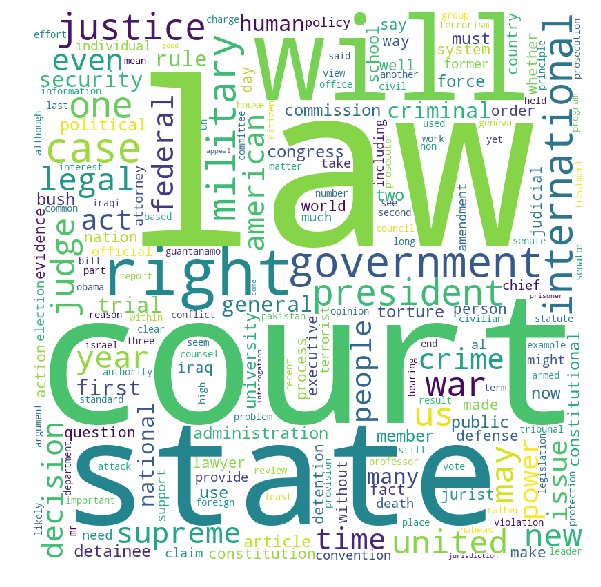

In [9]:
#Generate Wordcloud for US Commentary Articles
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                collocations = False,
                min_font_size = 10).generate(' '.join(usCommentary["Processed"]).lower()) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

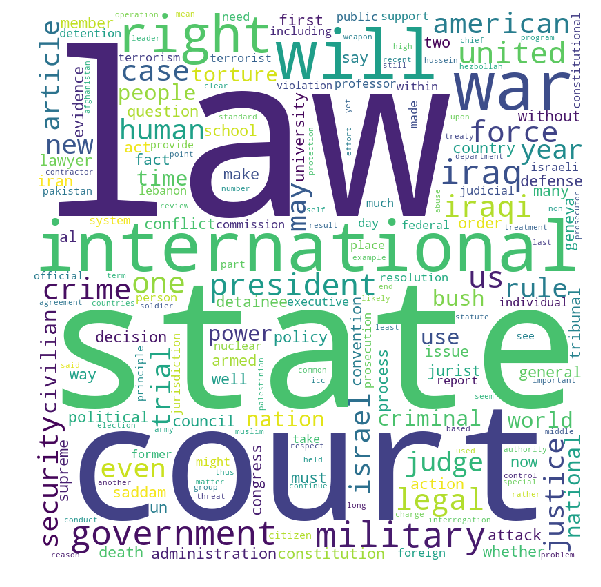

In [10]:
#Generate Wordcloud for Middle East Commentary Articles
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                collocations = False,
                min_font_size = 10).generate(' '.join(meCommentary["Processed"]).lower()) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [168]:
############################### MOVING ONTO LEXICON-BASED SENTIMENT ANALYSIS ###############################
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/imadrizvi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [185]:
#Here's the column where the vader scores will be ... vader scores include positive, negative, neutral, and compound scores
#Positive, negative, and neutral scores should sum up to 1, it represents the percent of the text in each category
#Compound scores is normalized overall sentiment score for text
vaderScores = [None] * len(allCommentary['Processed'])
vaderCompound = [None] * len(allCommentary['Processed'])
for i in range(len(allCommentary['Processed'])):
    vaderScores[i] = sid.polarity_scores(allCommentary['Processed'][i])
    vaderCompound[i] = vaderScores[i]['compound']

allCommentary['VaderScores'] = vaderScores
allCommentary['VaderCompound'] = vaderCompound

In [203]:
#The most negative articles, the links to the 5 most negative commentary articles according to this lexicon are below
#https://www.jurist.org/commentary/2005/11/new-rules-of-game-uk-terrorism-bill/
#https://www.jurist.org/commentary/2012/01/christopher-hale-eccc-torture/
#https://www.jurist.org/commentary/2013/10/ashish-goel-death-penalty/
#https://www.jurist.org/commentary/2014/09/chri...
#https://www.jurist.org/commentary/2015/01/mohamed-arafa-egypt-judiciaryphp/
allCommentary.sort_values(by=['VaderCompound'], ascending=True).head()

,Title,PubDate,Tags,Author,Affiliation,Link,Text,Processed,isUSA,isME,w2vProcessed,VaderScores,VaderCompound
196,New Rules of the Game: The UK Terrorism Bill,"Mon, 07 Nov 2005 13:01:00 +0000","Afghanistan, Burma, England, Iraq, Ireland, Is...",,,https://www.jurist.org/commentary/2005/11/new-...,"<p>JURIST Guest Columnist <a href=""http://law....","<p>JURIST Guest Columnist <a href=""http://law....",True,True,"JURIST Guest Columnist Richard Edwards, Princi...","{'neg': 0.209, 'neu': 0.699, 'pos': 0.093, 'co...",-1.0000
1919,ECCC Must Prosecute Those Responsible for Torture,"Tue, 31 Jan 2012 22:00:00 +0000",The Legacy of Guantanamo Bay,,,https://www.jurist.org/commentary/2012/01/chri...,"<p>JURIST Guest Columnist Christopher Hale, Se...","<p>JURIST Guest Columnist Christopher Hale, Se...",False,False,"JURIST Guest Columnist Christopher Hale, Senio...","{'neg': 0.214, 'neu': 0.703, 'pos': 0.084, 'co...",-1.0000
2391,A Rope for Rape?,"Mon, 21 Oct 2013 14:00:00 +0000","death penalty, India, rape, women's rights",,,https://www.jurist.org/commentary/2013/10/ashi...,"<p>JURIST Guest Columnist Ashish Goel, an LL.M...","<p>JURIST Guest Columnist Ashish Goel, an LL.M...",False,False,"JURIST Guest Columnist Ashish Goel, an LL.M. c...","{'neg': 0.353, 'neu': 0.592, 'pos': 0.055, 'co...",-1.0000
2566,Female Inmates and Sexual Assault,"Mon, 15 Sep 2014 23:00:00 +0000",,Christina Piecora,St. John's University School of Law,https://www.jurist.org/commentary/2014/09/chri...,<p><j:header>JURIST Guest Columnist Christina ...,<p><j:header>JURIST Guest Columnist Christina ...,False,False,"JURIST Guest Columnist Christina Piecora, St. ...","{'neg': 0.288, 'neu': 0.648, 'pos': 0.063, 'co...",-0.9999
2641,Egypt&apos;s Judiciary: Reform in the Criminal...,"Sun, 01 Feb 2015 01:21:00 +0000",Egypt,Mohamed 'Arafa,Alexandria University School of Law,https://www.jurist.org/commentary/2015/01/moha...,"<p class=""ui-box -border"">JURIST Guest Columni...","<p class=""ui-box -border"">JURIST Guest Columni...",False,False,JURIST Guest Columnist Mohamed 'Arafa of Alexa...,"{'neg': 0.216, 'neu': 0.686, 'pos': 0.098, 'co...",-0.9999


In [206]:
#The most positive articles, the links to the 5 most negative commentary articles according to this lexicon are below
#https://www.jurist.org/commentary/2006/01/judging-alito-us-supreme-court/
#https://www.jurist.org/commentary/2012/11/danielle-rudisill-campaign-finance/
#https://www.jurist.org/commentary/2007/02/rethinking-rule-of-law-efforts-in-iraq/
#https://www.jurist.org/commentary/2005/10/in-praise-of-treachery-relevance-of/
#https://www.jurist.org/commentary/2015/06/diana-ginn-canadian-religious-freedom/
allCommentary.sort_values(by=['VaderCompound'], ascending=False).head()

,Title,PubDate,Tags,Author,Affiliation,Link,Text,Processed,isUSA,isME,w2vProcessed,VaderScores,VaderCompound
218,Judging Alito: The US Supreme Court Selection ...,"Fri, 06 Jan 2006 13:01:00 +0000","Australia, Canada, Other, United Kingdom, Unit...",,,https://www.jurist.org/commentary/2006/01/judg...,"<p>JURIST Guest Columnist <a href=""http://www....","<p>JURIST Guest Columnist <a href=""http://www....",True,False,JURIST Guest Columnist Bryan Horrigan of Macqu...,"{'neg': 0.05, 'neu': 0.814, 'pos': 0.135, 'com...",0.9999
2198,More Campaign Finance Monitoring and Super PAC...,"Sat, 03 Nov 2012 16:00:00 +0000","Barack Obama, Buckley v. Valeo, Campaign Finan...",,,https://www.jurist.org/commentary/2012/11/dani...,"<p>JURIST Guest Columnist Danielle Rudisill, <...","<p>JURIST Guest Columnist Danielle Rudisill, <...",False,False,"JURIST Guest Columnist Danielle Rudisill, Stet...","{'neg': 0.038, 'neu': 0.736, 'pos': 0.226, 'co...",0.9999
570,Rethinking Rule of Law Efforts in Iraq,"Mon, 26 Feb 2007 13:01:00 +0000","Afghanistan, Democratic Republic of the Congo,...",,,https://www.jurist.org/commentary/2007/02/reth...,"<p>JURIST Guest Columnist Kevin Govern, Assist...","<p>JURIST Guest Columnist Kevin Govern, Assist...",True,True,"JURIST Guest Columnist Kevin Govern, Assistant...","{'neg': 0.048, 'neu': 0.823, 'pos': 0.129, 'co...",0.9999
173,In Praise of Treachery: The Relevance of Prior...,"Thu, 13 Oct 2005 12:01:00 +0000","Japan, Terrorism, United States, Video",,,https://www.jurist.org/commentary/2005/10/in-p...,"<p>JURIST Guest Columnist <a href=""http://www....","<p>JURIST Guest Columnist <a href=""http://www....",True,False,JURIST Guest Columnist Robert Schapiro of Emor...,"{'neg': 0.061, 'neu': 0.73, 'pos': 0.209, 'com...",0.9998
2700,Canadian Freedom of Religion Case,"Mon, 15 Jun 2015 12:02:27 +0000","multiculturalism, religious freedom, Supreme C...",Diana Ginn,Schulich School of Law,https://www.jurist.org/commentary/2015/06/dian...,"<p class=""ui-box -border"">JURIST Guest Columni...","<p class=""ui-box -border"">JURIST Guest Columni...",False,False,JURIST Guest Columnist Diana Ginn of Schulich ...,"{'neg': 0.034, 'neu': 0.782, 'pos': 0.184, 'co...",0.9998


In [207]:
#Make subsetted dataframe with only US Commentary Articles
usCommentary = allCommentary.loc[allCommentary["isUSA"] == True]

#Make subsetted dataframe with only Middle East Commentary Articles
meCommentary = allCommentary.loc[allCommentary["isME"] == True]

from matplotlib import pyplot

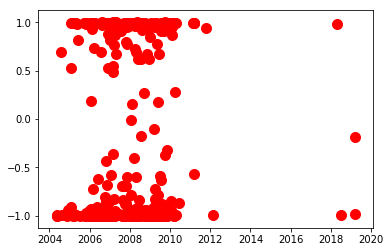

In [220]:
#Here is a graph of sentiment scores for Middle East commentary articles over time
dates = [pd.to_datetime(d) for d in meCommentary['PubDate']]
plt.scatter(dates, meCommentary['VaderCompound'], s =100, c = 'red')

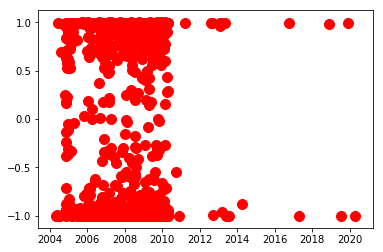

In [221]:
#Here is a graph of sentiment scores for United States commentary articles over time
dates = [pd.to_datetime(d) for d in usCommentary['PubDate']]
plt.scatter(dates, usCommentary['VaderCompound'], s =100, c = 'red')

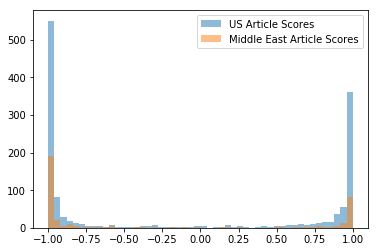

In [223]:
#Here is a graph of US vs ME article sentiment scores
pyplot.hist(usCommentary['VaderCompound'], 50, alpha=0.5, label='US Article Scores')
pyplot.hist(meCommentary['VaderCompound'], 50, alpha=0.5, label='Middle East Article Scores')
pyplot.legend(loc='upper right')
pyplot.show()

In [11]:
############################### MOVING ONTO UNSUPERVISED SENTIMENT ANALYSIS ###############################
#The following code comes from the Kaggle tutorial here: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial/data
#With some modification
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy
#Needed to run this command on terminal even after installing spacy: python -m spacy download en
nlp = spacy.load('en', disable=['ner', 'parser'])

In [12]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [13]:
#Make new column in dataframe where we will process specifically for word2vec
allCommentary['w2vProcessed'] = allCommentary["Processed"]

#Remove non alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in allCommentary['w2vProcessed'])

In [14]:
#Perform cleaning, the time to clean was about 5 minutes
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.19 mins


In [15]:
#df_clean has the cleaned data now, there are 3380 rows
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(3380, 1)

In [16]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [17]:
#Accounts for bigrams
#(if there are two wordss that appear together a lot, they might be one phrase to be considered together
bigram = Phraser(phrases)
sentences = bigram[sent]

In [19]:
#check the most frequent words 
#after lemmatization (changing tenses), removing stopwords
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
#Checking the number of unique words
len(word_freq)


45078

In [20]:
#Printing out the top 10 most frequent words:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['law',
 'court',
 'state',
 'case',
 'right',
 'government',
 'act',
 'legal',
 'issue',
 'rule']

In [22]:
#Now, we need to train the model
#Using the Gensim implementation of word2vec
import multiprocessing
from gensim.models import Word2Vec
# Count the number of cores in a computer to parallelize
cores = multiprocessing.cpu_count() 

In [25]:
#Specific parameters described here: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

w2v_model = Word2Vec(min_count=10, 
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [26]:
#Building vocab table
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.08 mins


In [27]:
#Training the model

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to train the model: 3.4 mins


In [37]:
#Find the word most similar to US
w2v_model.wv.most_similar(positive=["u_s"])

[('united_states', 0.562785267829895),
 ('washington_d', 0.4421192407608032),
 ('henceforth', 0.3463653028011322),
 ('ricardo', 0.3322075307369232),
 ('cole', 0.3283885717391968),
 ('black_site', 0.31228014826774597),
 ('military_personnel', 0.31190595030784607),
 ('iraq_afghanistan', 0.3074589967727661),
 ('glenn', 0.30698469281196594),
 ('overseas', 0.3066142201423645)]

In [39]:
word_vectors = w2v_model.wv

In [43]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [52]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=100, restrict_vocab=None)

[('determinable', 0.5307477712631226),
 ('malleable', 0.49577343463897705),
 ('procompetitive', 0.4914143979549408),
 ('gainful', 0.48815977573394775),
 ('commensurate', 0.48611971735954285),
 ('measurable', 0.47998541593551636),
 ('divergence', 0.4729364514350891),
 ('verifiable', 0.47212323546409607),
 ('distinctly', 0.47108423709869385),
 ('operationally', 0.46029168367385864),
 ('abnormal', 0.4564288854598999),
 ('misconception', 0.45472443103790283),
 ('impulse', 0.4526550769805908),
 ('differentiation', 0.4522271752357483),
 ('diminution', 0.4518979489803314),
 ('frustrating', 0.45047727227211),
 ('fgm', 0.4475845694541931),
 ('intrastate', 0.44679588079452515),
 ('unjustifiable', 0.4467630386352539),
 ('output', 0.44581174850463867),
 ('pluralistic', 0.4438406229019165),
 ('hidden', 0.44298213720321655),
 ('particularize', 0.44249171018600464),
 ('thc', 0.4366409182548523),
 ('varying', 0.436544805765152),
 ('loac', 0.43521761894226074),
 ('uncontested', 0.43479812145233154),
 (

In [79]:
import numpy as np

words = pd.DataFrame(list(word_vectors.vocab.keys()))
words.columns = ['words']

In [115]:
words['vectors'] = words['words'].apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words['vectors'].apply(lambda x: model.predict(x.reshape(1,-1))[0])
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [177]:
#See the words with the most positive sentiment score
words.sort_values(by=['sentiment_coeff'], ascending=False).head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
7852,deborah,"[0.018347267, -0.10245158, -0.24090727, 0.0501...",0,1,0.404854,0.404854
12335,ashutosh,"[0.12174722, -0.16379963, 0.21357518, 0.147085...",0,1,0.397839,0.397839
10943,ala,"[0.0070553264, 0.045331094, 0.03992521, 0.5114...",0,1,0.397094,0.397094
10601,awzar,"[0.22706999, 0.07381122, 0.37032968, -0.076724...",0,1,0.395420,0.395420
9490,te,"[-0.057002448, -0.23881072, 0.03009745, 0.1571...",0,1,0.388467,0.388467


In [178]:
#See the words with the most negative sentiment score
words.sort_values(by=['sentiment_coeff'], ascending=True).head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
7530,luckily,"[0.20642947, 0.03844909, -0.07234965, -0.17539...",1,-1,0.387088,-0.387088
10968,localize,"[-0.0114116855, 0.14291662, 0.03193129, 0.2249...",1,-1,0.379127,-0.379127
6272,idle,"[-0.0883594, -0.16466719, 0.07548712, -0.01519...",1,-1,0.377835,-0.377835
10317,retrospective,"[0.02773865, 0.0962239, 0.07571548, 0.26796204...",1,-1,0.376012,-0.376012
4391,inconsequential,"[0.02964483, -0.042129934, -0.0060750633, 0.06...",1,-1,0.374672,-0.374672


In [161]:
#Notice how both the words "good" and "bad" have the same sentiment score — there's an issue here likely from the names and lack of a third/neutral category
print(words.loc[words['words'] == 'good']["sentiment_coeff"])
print(words.loc[words['words'] == 'bad']["sentiment_coeff"])

224   -0.147412
Name: sentiment_coeff, dtype: float64
316   -0.122046
Name: sentiment_coeff, dtype: float64


In [149]:
#Need to finish up the TF-IDF weighting
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.title)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.title)

NameError: name 'file_weighting' is not defined